In [1]:
import numpy as np
import copy
import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

import mylibrary.nnlib as tnn

In [2]:
class KLipschitzNet_Force(tnn.Layer):
    
    def __init__(self, layer_dims, optimizer, output_activation=tnn.Linear(), K=1):
        layer_list = []
        self.K = K
        for i in range(len(layer_dims)-1):
            if i+2 == len(layer_dims):
                actv = output_activation
            else:
                actv = tnn.Relu()
            layer = tnn.NonLinearLayer(layer_dims[i], layer_dims[i+1], activation=actv, optimizer=optimizer)
            layer_list.append(layer)

        self._net = tnn.AutoForm()
        self._net.layerList = layer_list
        
#         self.preprocess()
        
    def preprocess(self):
        ## for all hidden layers
        for layer in self._net.layerList[:-1]:
            norm = np.linalg.norm(layer.weights,1,0, keepdims=True)/self.K
            layer.weights /= norm
        ## if the problem is regression, restirct the last layer for K-Lipschitz
        ## output layer
        layer = self._net.layerList[-1]
        norm = np.linalg.norm(layer.weights,1,0, keepdims=True)
        ## renormalize if the norm is greater than 1.
        re_norm = np.maximum(norm, self.K)
        layer.weights /= re_norm
        return
    
    def get_dydx(self):
        dy_ = np.ones_like(self._net.layerList[-1].output)
        dydx = self._net.backward(dy_)
        norm = np.linalg.norm(dydx, 2, 1, keepdims=True)
        return norm
    
    def force_lipschitz(self, dydx):
        max_slope = np.max(np.abs(dydx))
        scaler = max_slope/self.K
        if scaler > 1:#+1e-7:
            self._net.layerList[-1].weights /= scaler
            ## scaling the bias as well might be good idea
            self._net.layerList[-1].bias /= scaler

    def force_lipschitz_iteratively(self, xx, n_iter=5):
        for i in range(n_iter):
            yout = self.forward(xx)
            dydx = self.get_dydx()
            max_slope = np.abs(dydx).max()
            scaler = max_slope/self.K
            if scaler > 1:
                scaler += 1e-7
                self._net.layerList[-1].weights /= scaler
                self._net.layerList[-1].bias /= scaler
            else:
                break
        return

            
    def gradient_multiplier(self, dydx):
        x_ = dydx/self.K

        ## A shape function clipped
#         dy_ = np.maximum(1-np.abs(x_), -0.5)
        ## Exponential/gaussian function scaled and shifted
#         dy_ = 1.1566666*(np.exp(-2*x_**2) - 0.13548)
        ## Bump function.. scaled and shifted
#         dy_ = np.exp(1/(0.80001*(np.clip(x_, -1.02, 1.02)**10)-1))/0.3679-0.01831
#         dy_ = (np.exp(1/(0.99*np.clip(x_, -1.001, 1.001)**10-1))-0.0000287)/0.367866
        
        dy_ = (np.exp(1/(0.99*np.clip(x_, -1.001, 1.001)**4-1)))/0.367866 - 2.587e-11
        ## Bump function
#         dy_ = np.exp(1/(np.clip(x_, -1+1e-8, 1-1e-8)**2-1))/0.3679
        ## N order power of x inverted
#         dy_ = np.maximum(1-(x_**6), -0.5)
        
        return dy_
        
    def forward(self,inputs):
        out = self._net.forward(inputs)
        return out
    
    def backward(self, del_output, dydx):
        mult = self.gradient_multiplier(dydx)
        dx = self._net.backward(del_output*mult)
        return dx
    
    def update(self):  
        self._net.update()

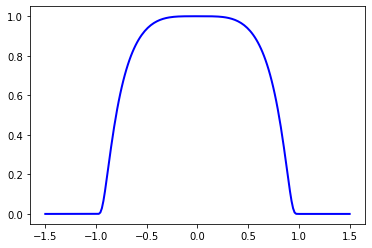

In [4]:
%matplotlib inline
net = KLipschitzNet_Force([1,1,1], tnn.SGD())
x = np.linspace(-1.5,1.5, 200)
plt.plot(x, net.gradient_multiplier(x), lw=2, color='b')

### 1D Regression Dataset

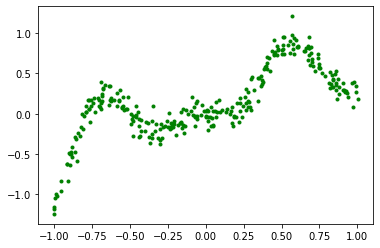

In [5]:
x = np.linspace(0,1,300)
noise = np.random.normal(0,0.02, x.shape)
x = x + noise
x = np.sort(x)

y= (2 * np.sin(10*x) + np.cos(20 * x - 3) + 3 * np.log(10*x + 0.5) - 4)/6.
noise = np.random.normal(0,0.1, x.shape)
y = y + noise
# y = -y

x = x*2
x = x - x.mean() # good practice to zero-center x in linear mapping
xx = x.reshape(-1,1)
yy = y.reshape(-1,1)

%matplotlib inline
plt.scatter(x, y, marker='.', color='g')
plt.show()

In [6]:
optim = tnn.Adam(0.01)
net = KLipschitzNet_Force([1,9,1], optim)

In [7]:
%matplotlib tk
fig = plt.figure(figsize=(10,6))
ax = fig.add_subplot(111)

for epoch in range(100000):
    yout = net.forward(xx)
    dy = yout - yy
    dydx = net.get_dydx()
    dx = net.backward(dy, dydx)
    net.update()
    
    yout = net.forward(xx)
    dydx = net.get_dydx()
    net.force_lipschitz(dydx)
    
    if epoch%500 == 0:
        
        error = (dy**2).mean()
        print(epoch, 'Error = ', error)
        ax.clear()
        ax.scatter(x, y, marker='.', color='g')
        ax.plot(x, yout.reshape(-1), color='r', lw=3, label='yout')
        ax.scatter(x, dydx.reshape(-1), color='c', marker='.', label='dydx')  
        ax.hlines([1,-1], xmin=x.min(), xmax=x.max())
        ax.legend()

        fig.canvas.draw()
        plt.pause(0.01)
        print("\n")
        if error < 0.00025:
            print('fitted to our expectation')
            break

0 Error =  1.886275305518645


500 Error =  0.05447653223541303


1000 Error =  0.05206211919508117


1500 Error =  0.0512812713025096


2000 Error =  0.051364619322870314


2500 Error =  0.050937501607343984


3000 Error =  0.05045225697403281


3500 Error =  0.050384010300587284


4000 Error =  0.04824951363193409


4500 Error =  0.04812685051798934


5000 Error =  0.04836188602677553


5500 Error =  0.04841536867041478


6000 Error =  0.04840565455868703


6500 Error =  0.048386019296375156


7000 Error =  0.04834919353288157


7500 Error =  0.04772387748131172


8000 Error =  0.047060462764453775


8500 Error =  0.046709744730224226


9000 Error =  0.05187040313003493


9500 Error =  0.051703263187353805


10000 Error =  0.05163372824733434


10500 Error =  0.051582045860908254


11000 Error =  0.05153094545197285


11500 Error =  0.05146988907002703


12000 Error =  0.051389324963877124


12500 Error =  0.051279829370967665


13000 Error =  0.05113287191929484


13500 Error =  0.0

TclError: invalid command name "."

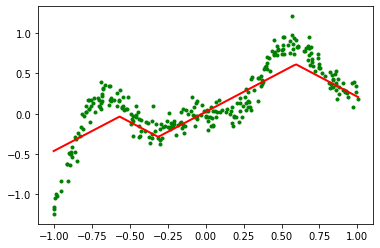

In [8]:
%matplotlib inline
plt.scatter(x, y, marker='.', color='g')
plt.plot(x, yout.reshape(-1), color='r', lw=2)

In [9]:
y = y/0.4
yy = y.reshape(-1,1)

### 2D Regression Dataset

In [10]:
num_points = 50
X1 = np.linspace(-2.5, 1.5, num_points)
# X1 = np.linspace(-2.5, 0, num_points)
X2 = np.linspace(-2, 4, num_points)
X1, X2 = np.meshgrid(X1, X2)
Y = np.sin(np.sqrt(X1**2 + X2**2))*2-1.

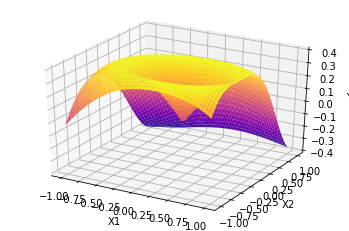

In [11]:
####Scaling the data to range -1,1
X1 = 2*(X1 - X1.min())/(X1.max() - X1.min()) -1
X2 = 2*(X2 - X2.min())/(X2.max() - X2.min()) -1
Y = 2*(Y - Y.min())/(Y.max() - Y.min()) -1
Y = Y*0.4

x1 = X1.reshape(-1)
x2 = X2.reshape(-1)

xx = np.c_[x1, x2]
yy = Y.reshape(-1,1)

%matplotlib inline
fig = plt.figure()
ax = fig.gca(projection='3d')
ax.plot_surface(X1, X2, Y, cmap='plasma')
ax.set_xlabel('X1')
ax.set_ylabel('X2')
ax.set_zlabel('Y')
plt.show()

In [21]:
optim = tnn.Adam(0.003)
net = KLipschitzNet_Force([2, 10, 1,], optim)

In [168]:
%matplotlib tk
fig = plt.figure()
ax = fig.gca(projection='3d')

for epoch in range(100000):

    yout = net.forward(xx)
    dy = yout - yy
    dydx = net.get_dydx()
    dx = net.backward(dy, dydx)
    net.update()
    
    yout = net.forward(xx)
    dydx = net.get_dydx()
    net.force_lipschitz(dydx)
    
    if epoch%100 == 0:
        
        error = (dy**2).mean()
        print(epoch, 'Error = ', error)
        ax.clear()
        
        ax.scatter(X1, X2, Y)
        ax.scatter(X1, X2, yout.reshape(-1), color='r', marker='.')
        ax.set_xlabel('X1')
        ax.set_ylabel('X2')
        ax.set_zlabel('Y')
        
        fig.canvas.draw()
        plt.pause(0.01)
        print("\n")
        if error < 0.00025:
            print('fitted to our expectation')
            break

0 Error =  0.5214061395070656


100 Error =  0.031347516342638916


200 Error =  0.012129798695994185


300 Error =  0.006570132730843439


400 Error =  0.005288997565078387


500 Error =  0.004835046273064823


600 Error =  0.00462317078688708


700 Error =  0.0045109446832590746


800 Error =  0.0044345789553248555


900 Error =  0.004351805898977041


1000 Error =  0.004253761328702091


1100 Error =  0.004150381970362335


1200 Error =  0.004045461110149902


1300 Error =  0.0039357658011632615


1400 Error =  0.00385437828098609


1500 Error =  0.003799993739771736


1600 Error =  0.003770999425576234


1700 Error =  0.0037517278405066073


1800 Error =  0.003131244057220455


1900 Error =  0.003152569617930172


2000 Error =  0.003164764465910072


2100 Error =  0.0031684740179588567


2200 Error =  0.0031724316291711317


2300 Error =  0.0031737788645381897


2400 Error =  0.003174203569514802


2500 Error =  0.0031751883270552763


2600 Error =  0.0031758502903155195


TclError: invalid command name "."

In [169]:
dy_ = np.ones_like(net._net.layerList[-1].output)
dydx = net._net.backward(dy_)
norm = np.linalg.norm(dydx, 2, 1, keepdims=True)
norm

array([[0.18827481],
       [0.18827481],
       [0.18827481],
       ...,
       [0.81917477],
       [0.81917477],
       [0.81917477]])

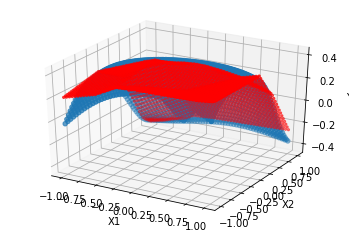

In [170]:
%matplotlib inline
fig = plt.figure()
ax = fig.gca(projection='3d')
ax.scatter(X1, X2, Y)
ax.scatter(X1, X2, yout.reshape(-1), color='r', marker='.')
ax.set_xlabel('X1')
ax.set_ylabel('X2')
ax.set_zlabel('Y')
plt.show()

## classification

In [4]:
from sklearn.datasets import make_moons

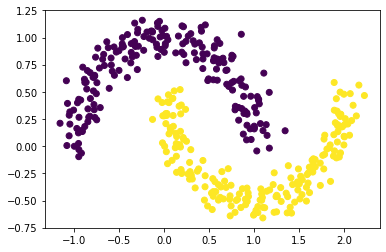

In [89]:
X, y = make_moons(n_samples=400, noise=0.1)
x1 = X[:,0]
x2 = X[:,1]

xx = X
yy = y.astype(float).reshape(-1,1)
%matplotlib inline
plt.scatter(x1, x2, c=y)

In [79]:
optim = tnn.Adam(0.01)
net = KLipschitzNet_Force([2, 20, 1,], optim, K=10) ### lipschitz constraint before sigmoid

In [80]:
%matplotlib tk
fig = plt.figure()
ax = fig.add_subplot(111)

for epoch in range(100000):
    
    yout = net.forward(xx)
    dy = tnn.SigmoidCrossEntropyBinary.del_loss(yout, yy)
    dydx = net.get_dydx()
    dx = net.backward(dy, dydx)
    net.update()
    
    yout = net.forward(xx)
    dydx = net.get_dydx()
    net.force_lipschitz(dydx)
    
    
    if epoch%500 == 0:
        
        error = tnn.SigmoidCrossEntropyBinary.loss(yout, yy)
        print(epoch, 'Error = ', error)
        
        out = (yout>0).astype(float)
        ax.clear()
        ax.scatter(x1, x2, c=y)
        ax.scatter(x1, x2, c=out.reshape(-1), marker='.')

        fig.canvas.draw()
        plt.pause(0.01)
        print("\n")
        if error < 0.00025:
            print('fitted to our expectation')
            break

0 Error =  0.4786327647765235


500 Error =  0.19450075460662283


1000 Error =  0.16574681736047078


1500 Error =  0.10942463149797922


TclError: invalid command name "."

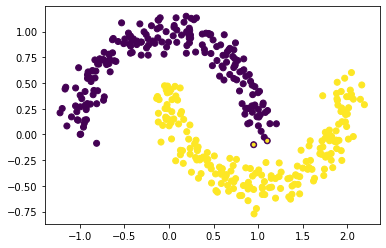

In [180]:
%matplotlib inline
plt.scatter(x1, x2, c=y)
plt.scatter(x1, x2, c=out.reshape(-1), marker='.')

#### 3D visualization

In [131]:
optim = tnn.Adam(0.01)
net = KLipschitzNet_Force([2, 20, 1,], optim, output_activation=tnn.Sigmoid(), K=2)

In [134]:
%matplotlib tk
fig = plt.figure(figsize=(15,6))
ax = fig.add_subplot(121,projection='3d')
ax2 = fig.add_subplot(122)
ax.view_init(28,20)

for epoch in range(100000):

    yout = net.forward(xx)
    dy = tnn.CrossEntropyBinary.del_loss(yout, yy)
#     dy = yout-yy
    dydx = net.get_dydx()
    dx = net.backward(dy, dydx)
    net.update()
    
#     net.force_lipschitz_iteratively(xx)
    yout = net.forward(xx)
    dydx = net.get_dydx()
    net.force_lipschitz(dydx)
    dydx = net.get_dydx()
    
    if epoch%100 == 0:
        
        error = tnn.CrossEntropyBinary.loss(yout, yy)
        print(epoch, 'Error = ', error)
        print(dydx.max())
#         print(net._net.layerList[-1].del_zee)
        
        ax.clear()
        ax.scatter(x1, x2, y, c=y)
        ax.scatter(x1, x2, yout.reshape(-1), c=yout, marker='.')
        ax.set_xlabel('X1')
        ax.set_ylabel('X2')
        ax.set_zlabel('Y')
        
        out = (yout>0.5).astype(float)
        ax2.clear()
        ax2.scatter(x1, x2, c=y)
        ax2.scatter(x1, x2, c=out.reshape(-1), marker='.')

        fig.canvas.draw()
        plt.pause(0.01)
        print("\n")
        if error < 0.00025:
            print('fitted to our expectation')
            break

0 Error =  0.12199355310269965
2.1707414882482925


100 Error =  0.036003253315034525
3.0000000000000004


200 Error =  0.03301257079824857
3.0


300 Error =  0.03250127751620615
3.0


400 Error =  0.03215878049338844
2.9999999999999996


500 Error =  0.0319870832513036
3.0000000000000004


600 Error =  0.03186537800125996
3.0000000000000004


700 Error =  0.03179919236180811
3.0


TclError: invalid command name "."

In [133]:
net.K = 3

### Testing lipsticz constant on single neuron

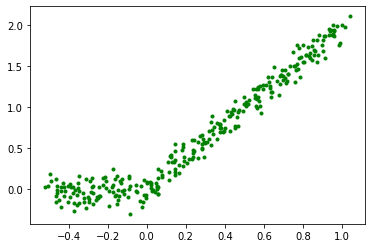

In [4]:
x = np.linspace(-0.5,1,300)
noise = np.random.normal(0,0.02, x.shape)
x = x + noise
x = np.sort(x)

y= tnn.LeakyRelu().forward(x)*2
noise = np.random.normal(0,0.1, x.shape)
y = y + noise

xx = x.reshape(-1,1)
yy = y.reshape(-1,1)

%matplotlib inline
plt.scatter(x, y, marker='.', color='g')
plt.show()

In [3]:
optim = tnn.Adam(0.01)
net = KLipschitzNet_Force([1,1,1], optim)

In [18]:
%matplotlib tk
fig = plt.figure(figsize=(10,6))
ax = fig.add_subplot(111)

for epoch in range(100000):
    yout = net.forward(xx)
    dy = yout - yy
    dydx = net.get_dydx()
    dx = net.backward(dy, dydx)
    net.update()
    
    yout = net.forward(xx)
    dydx = net.get_dydx()
    net.force_lipschitz(dydx)
    
    if epoch%500 == 0:
        
        error = (dy**2).mean()
        print(epoch, 'Error = ', error)
        ax.clear()
        ax.scatter(x, y, marker='.', color='g')
        ax.plot(x, yout.reshape(-1), color='r', lw=3, label='yout')
        ax.scatter(x, dydx.reshape(-1), color='c', marker='.', label='dydx')  
        ax.hlines([1,-1], xmin=x.min(), xmax=x.max())
        ax.legend()

        fig.canvas.draw()
        plt.pause(0.01)
        print("\n")
        if error < 0.00025:
            print('fitted to our expectation')
            break

0 Error =  0.509780800674629


500 Error =  0.13263239919737424


1000 Error =  0.13274771567999608


1500 Error =  0.13277610428548928


2000 Error =  0.1329743836486361


2500 Error =  0.13287736469022213


3000 Error =  0.13284223512032137


3500 Error =  0.13322050930256946


4000 Error =  0.13330224984611808


4500 Error =  0.1342176296329343


5000 Error =  0.13422513584866727


5500 Error =  0.13476918210284983


6000 Error =  0.13497156553872786


6500 Error =  0.13504918647532183


7000 Error =  0.13532030514932417


7500 Error =  0.1366250806847787


8000 Error =  0.1347258106560213


8500 Error =  0.1365141017057048


9000 Error =  0.13527359344565965


9500 Error =  0.13817691149308137


10000 Error =  0.13707322712518008


10500 Error =  0.13640463388343826


11000 Error =  0.1376551962411843


11500 Error =  0.13684835300639359


12000 Error =  0.1321498756163652


12500 Error =  0.13486551900649354


13000 Error =  0.13688286420422272


13500 Error =  0.13661303489359758

TclError: invalid command name "."

In [17]:
yy = 4*yy #4, 0.25
y = yy.reshape(-1)

In [5]:
def gradient_multiplier_noisy(self, dydx):
    x_ = dydx/self.K
#     dydx = dydx + np.random.normal(scale=0.5, size=dydx.shape)
    

    ## A shape function clipped
#         dy_ = np.maximum(1-np.abs(x_), -0.5)
    ## Exponential/gaussian function scaled and shifted
#         dy_ = 1.1566666*(np.exp(-2*x_**2) - 0.13548)
    ## Bump function.. scaled and shifted
#         dy_ = np.exp(1/(0.80001*(np.clip(x_, -1.02, 1.02)**10)-1))/0.3679-0.01831
#         dy_ = (np.exp(1/(0.99*np.clip(x_, -1.001, 1.001)**10-1))-0.0000287)/0.367866

    dy_ = (np.exp(1/(0.99*np.clip(x_, -1.001, 1.001)**4-1)))/0.367866 - 2.587e-11
    ## Bump function
#         dy_ = np.exp(1/(np.clip(x_, -1+1e-8, 1-1e-8)**2-1))/0.3679
    ## N order power of x inverted
#         dy_ = np.maximum(1-(x_**6), -0.5)

#     dy_=  np.maximum(dy_, 1e-2)
#     dy_[dy_<0] = 1e-5
    dy_ = dy_ + np.random.normal(scale=0.0001, size=dy_.shape)

    return dy_

In [6]:
from types import MethodType
net.gradient_multiplier = MethodType(gradient_multiplier_noisy, net)